In [1]:
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

import open_clip
import cv2
from sentence_transformers import util

import os
from torchvision import transforms as T
import pandas as pd
from Utils.Dataloader import CropDataset
import matplotlib.pyplot as plt
from Utils.TextToImage import unique_char_mapping
from Utils.Filters import applyTransforms

from PIL import Image
import numpy as np
import torch

from SketchKeras.sketch_model import SketchKeras
import Utils.sketchkeras as SK 
import Utils.Predict as P 
from pytorch_fid import fid_score
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

from image_similarity_measures.evaluate import evaluation

PATCH_SIZE = 32

image = Image.open("image3.png").resize((2048, 2048))
sketch = Image.open("sketch3.png").resize((2048, 2048))
ascii_lines = Image.open("output3.png").resize((2048, 2048))
bw = Image.open("sit_toyosu.png").convert("L").resize((2048, 2048))
tone = Image.open("converted_sit_toyosu.png").resize((2048, 2048))

/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/phasepack/tools.py:11: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  warnings.warn("""


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [3]:
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1

In [4]:
def generateScore(image1, image2):
    # test_img = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    # data_img = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    img1 = imageEncoder(image1)
    img2 = imageEncoder(image2)
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score

In [5]:
def extract_patches(image, n, m, filename=None):  
    patches = []
    image = np.array(image,float)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height
    
    if filename:
        os.makedirs(filename, exist_ok=True)
        for i, patch in enumerate(patches):
            cv2.imwrite(f"{filename}/{filename}_{i}.png", patch)

    return np.array([patch for patch in patches]), images_width, images_height

In [6]:
ascii_imgs, ascii_w, ascii_h = extract_patches(ascii_lines, PATCH_SIZE, PATCH_SIZE, filename="ascii_patches")
sketch_imgs, sketch_w, sketch_h = extract_patches(sketch, PATCH_SIZE, PATCH_SIZE, filename="sketch_patches")

In [7]:
ascii_batch = []
for ascii_img in ascii_imgs:
    ascii_batch.append(torch.from_numpy(ascii_img).unsqueeze(0).unsqueeze(3).permute(0, 3, 1, 2))
    
sketch_batch = []
for sketch_img in sketch_imgs:
    sketch_batch.append(torch.from_numpy(sketch_img).unsqueeze(0).unsqueeze(3).permute(0, 3, 1, 2))
    

In [8]:
# scores = []
scores_ssim = []
# scores_msssim = []

for ascii_img, sketch_img in zip(ascii_batch, sketch_batch):
    scores_ssim.append(ssim(ascii_img, sketch_img, data_range=255, size_average=False, nonnegative_ssim=True))
    # scores_msssim.append(ms_ssim(ascii_img, sketch_img, data_range=255, size_average=False))



# for ascii_img, sketch_img in zip(ascii_imgs, sketch_imgs):
#     scores.append(generateScore(ascii_img, sketch_img))

In [9]:
tone_imgs, _, _ = extract_patches(tone, PATCH_SIZE, PATCH_SIZE, filename="tone_patches")
bw_imgs, _, _ = extract_patches(bw, PATCH_SIZE, PATCH_SIZE, filename="bw_patches")

In [10]:
scores_tone = []
for tone_img, bw_img in zip(tone_imgs, bw_imgs):
    scores_tone.append(generateScore(tone_img, bw_img))

In [11]:
for i, score in enumerate(scores_ssim):
    print(f'Image {i} : {(score.item()*100):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 100.00%
Image 1 : 100.00%
Image 2 : 100.00%
Image 3 : 100.00%
Image 4 : 100.00%
Image 5 : 100.00%
Image 6 : 100.00%
Image 7 : 100.00%
Image 8 : 100.00%
Image 9 : 100.00%
Image 10 : 100.00%
Image 11 : 100.00%
Image 12 : 100.00%
Image 13 : 100.00%
Image 14 : 100.00%
Image 15 : 100.00%
Image 16 : 100.00%
Image 17 : 100.00%
Image 18 : 100.00%
Image 19 : 100.00%
Image 20 : 100.00%
Image 21 : 100.00%
Image 22 : 100.00%
Image 23 : 100.00%
Image 24 : 100.00%
Image 25 : 100.00%
Image 26 : 100.00%
Image 27 : 100.00%
Image 28 : 100.00%
Image 29 : 100.00%
Image 30 : 100.00%
Image 31 : 100.00%
Image 32 : 100.00%
Image 33 : 100.00%
Image 34 : 100.00%
Image 35 : 100.00%
Image 36 : 100.00%
Image 37 : 100.00%
Image 38 : 100.00%
Image 39 : 100.00%
Image 40 : 100.00%
Image 41 : 100.00%
Image 42 : 100.00%
Image 43 : 100.00%
Image 44 : 100.00%
Image 45 : 100.00%
Image 46 : 100.00%
Image 47 : 100.00%
Image 48 : 100.00%
Image 49 : 100.00%
Image 50 : 100.00%
Image 51 : 100.00%
Image 52 : 100.00%
Ima

In [12]:
sketch_torch = torch.from_numpy(np.array(sketch, float)).unsqueeze(0).unsqueeze(3).permute(0, 3, 1, 2)
ascii_torch = torch.from_numpy(np.array(ascii_lines, float)).unsqueeze(0).unsqueeze(3).permute(0, 3, 1, 2)
score_msssim = ms_ssim(ascii_torch, sketch_torch, data_range=255, size_average=False)
scores_ssim = ssim(ascii_torch, sketch_torch, data_range=255, size_average=False)

In [13]:
for i, score_tone in enumerate(scores_tone):
    print(f'Image {i} : {(score_tone):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 34.99%
Image 1 : 34.43%
Image 2 : 35.51%
Image 3 : 37.88%
Image 4 : 46.84%
Image 5 : 44.54%
Image 6 : 43.47%
Image 7 : 40.48%
Image 8 : 39.49%
Image 9 : 43.53%
Image 10 : 36.58%
Image 11 : 33.84%
Image 12 : 45.57%
Image 13 : 44.43%
Image 14 : 42.65%
Image 15 : 37.46%
Image 16 : 37.32%
Image 17 : 41.89%
Image 18 : 44.68%
Image 19 : 43.69%
Image 20 : 34.68%
Image 21 : 43.93%
Image 22 : 42.78%
Image 23 : 35.95%
Image 24 : 33.52%
Image 25 : 36.20%
Image 26 : 43.22%
Image 27 : 40.91%
Image 28 : 45.16%
Image 29 : 43.95%
Image 30 : 41.72%
Image 31 : 37.57%
Image 32 : 36.18%
Image 33 : 41.50%
Image 34 : 44.36%
Image 35 : 45.31%
Image 36 : 45.66%
Image 37 : 42.70%
Image 38 : 41.78%
Image 39 : 38.43%
Image 40 : 39.49%
Image 41 : 41.01%
Image 42 : 45.38%
Image 43 : 45.41%
Image 44 : 44.76%
Image 45 : 42.87%
Image 46 : 42.29%
Image 47 : 38.94%
Image 48 : 38.89%
Image 49 : 42.23%
Image 50 : 44.95%
Image 51 : 46.87%
Image 52 : 44.82%
Image 53 : 43.16%
Image 54 : 42.90%
Image 55 : 40.24%
Im

Image similarity patches: 42.02%
Image similarity full: 47.83%


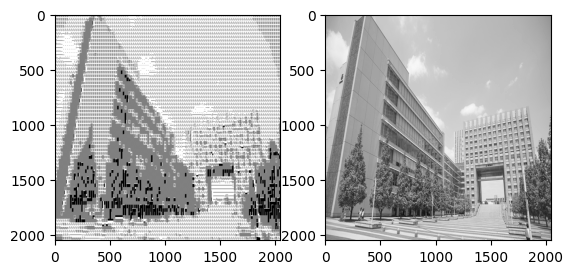

In [15]:
image_mean = np.array(scores_tone).mean()
print(f'Image similarity patches: {(image_mean):.2f}%')
print(f'Image similarity full: {(generateScore(np.array(bw),np.array(tone))):.2f}%')
# print(f'FID score : {FID_score}')
plt.subplot(1, 2, 1)
plt.imshow(tone, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(bw, cmap='gray')
plt.show()

Image ssim patches: 78.63597870787551%
Image ssim : 78.63597870787551%
Image msssim : 61.971112338393894%


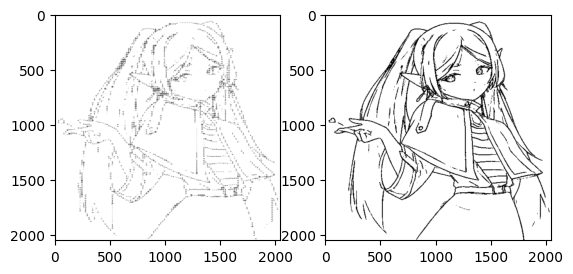

In [16]:
image_mean = np.array(scores_ssim).mean()
print(f'Image ssim patches: {(image_mean*100)}%')
print(f'Image ssim : {(scores_ssim.item()*100)}%')
print(f'Image msssim : {(score_msssim.item()*100)}%')
# print(f'FID score : {FID_score_tone}')
plt.subplot(1, 2, 1)
plt.imshow(ascii_lines, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sketch, cmap='gray')
plt.show()

In [40]:
evaluation("sketch3.png", "output3.png", metrics=["fsim", "rmse", "ssim"])

/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/image_similarity_measures/quality_metrics.py:171: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/image_similarity_measures/quality_metrics.py:171: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/image_similarity_measures/quality_metrics.py:188: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/image_similarity_measures/quality_metrics.py:297: RuntimeWarning: invalid value encountered in divide
  val = np.clip(numerator / denominator, -1, 1)
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/image_similarity_measures/quality_metrics.py:276: RuntimeWarning: invalid value encountered 

{'fsim': 0.3861740740723137,
 'issm': 0.0,
 'psnr': 36.405831360269346,
 'rmse': 0.015123152174055576,
 'sam': 0.0,
 'sre': 62.59266042853863,
 'ssim': 0.9186333035279256,
 'uiq': 0.00445369653079549}